Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Extract interface node from sub_2 and sub_1
Interface nodes from sub_1 and sub_2 already extracted


<IPython.core.display.Javascript object>


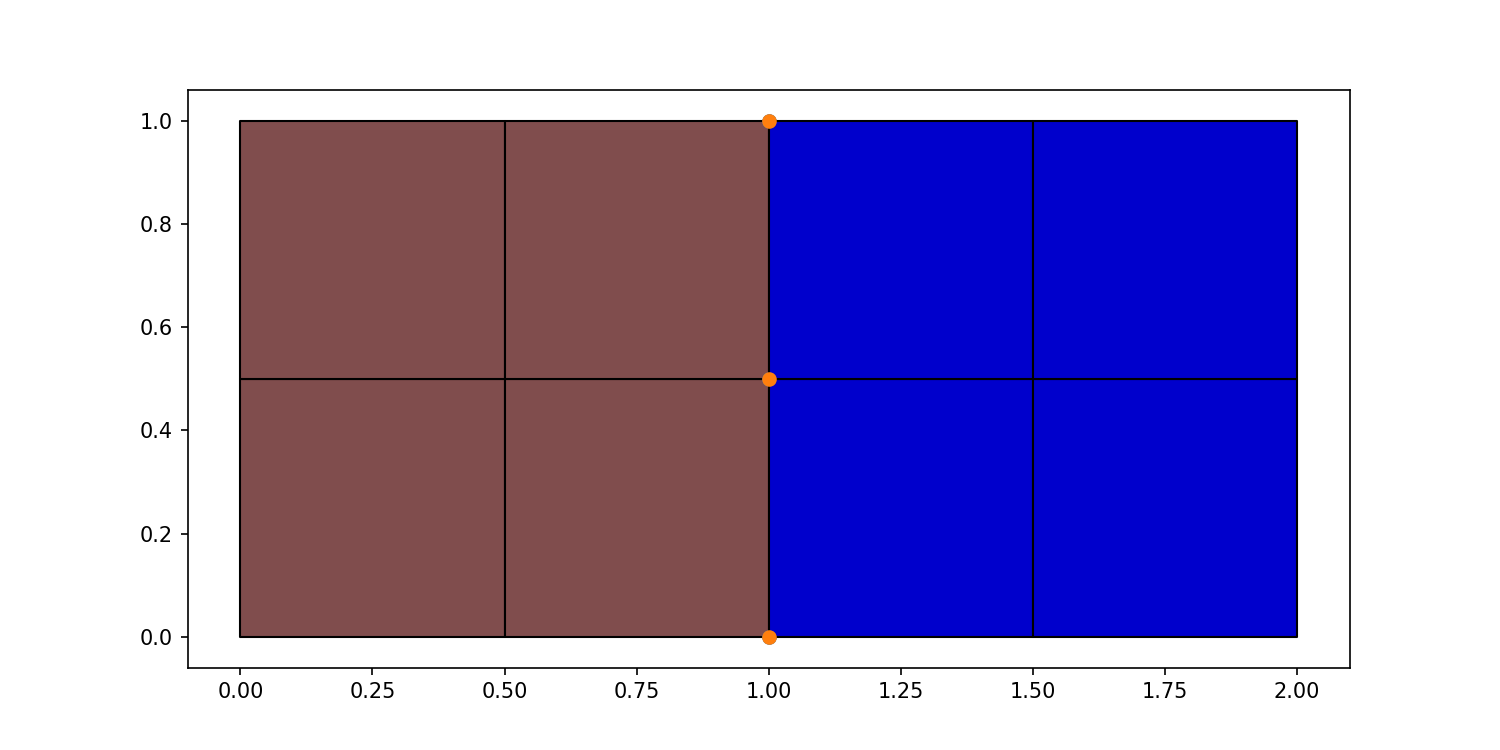

In [1]:
%matplotlib notebook
import sys 
import pandas as pd
#sys.path.append('H:\TUM-PC\Dokumente\Projects\AMfe')

import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy

sys.path.insert(0,'..')
from pyfeti.src.utils import OrderedSet, Get_dofs, save_object
import collections

msh_dict = {}
msh_dict[1] = mshfile = amfe.amfe_dir('meshes/test_meshes/geo_hole_quad_part_4.msh')
msh_dict[2] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
msh_dict[3] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_2quad_mesh.msh')
msh_dict[4] = mshfile = amfe.amfe_dir('meshes/test_meshes/4_partitions_quad_mesh.msh')


domain_id = {}
domain_id[1] = 8
domain_id[2] = 3
domain_id[3] = 3
domain_id[4] = 3

# select mesh to be plotted
mesh_id = 2
mshfile = msh_dict[mesh_id]

m = amfe.Mesh()
m.import_msh(mshfile)


# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)


# splitting physical grops

m.split_in_groups()

# plotting boundary elements
#amfe.plot_boundary_1d(m)


# plotting mesh
#amfe.plot_submesh(m.groups[domain_id[mesh_id]])


# setting boundary condition
# selecting subdomain for boundary condition
sub_dir = m.get_submesh('phys_group',1)
sub_neu = m.get_submesh('phys_group',2)

value = 5.0E9
neu = amfe.boundary.Boundary(sub_neu,value,'normal')
diri = amfe.boundary.Boundary(sub_dir,0,'xy','dirichlet')


# setting main domain for FE calculation
domain = m.set_domain('phys_group', domain_id[mesh_id])
domain.set_material(my_material)
domain.append_bondary_condition(neu)
domain.append_bondary_condition(diri)
domain.split_in_partitions()

fig, ax10 = plt.subplots(figsize=(10,5))
amfe.plot_domain(domain,ax=ax10)

plt.show()


In [ ]:
#plt.savefig('mesh.png')

In [ ]:
scale = 1
my_system = amfe.MechanicalSystem()
my_system.set_mesh_obj(m)
my_system.set_domain(domain_id[mesh_id],my_material)
my_system.apply_dirichlet_boundaries(1, 'xy')
my_system.apply_neumann_boundaries(2, value, 'normal')

K_global = my_system.assembly_class.assemble_k_and_f()
save_object(K_global,'K_global.pkl')

In [ ]:
# creating a dataframe based on id_matrix node, direction -> dof
id_matrix = my_system.assembly_class.id_matrix
id_map_df = pd.DataFrame.from_dict(id_matrix, columns=['x','y'],orient='index')

In [ ]:
id_map_df



In [ ]:
list(id_map_df['x'][[0,1,2]])

In [ ]:
g1 = m.groups[1] # Dirichlet
g2 = m.groups[2] # Neumann 
g3 = m.groups[3] # Domain

In [ ]:
g1.global_node_list

In [ ]:
g2.global_node_list

In [ ]:
g3.global_node_list

In [ ]:


gdof = Get_dofs(id_map_df)

dir_dofs = gdof.get(g1.global_node_list,'xy')
neu_dofs_y = gdof.get(g2.global_node_list,'y')
neu_dofs_x = gdof.get(g2.global_node_list,'x')
all_dofs = gdof.get(g3.global_node_list,'xy')

dof_dict = collections.OrderedDict()
dof_dict['dirichlet'] = OrderedSet(dir_dofs)
dof_dict['neu_x'] = OrderedSet(neu_dofs_x)
dof_dict['neu_y'] = OrderedSet(neu_dofs_y)
dof_dict['all'] = OrderedSet(all_dofs)
dof_dict['internal'] = dof_dict['all'] - (dir_dofs+neu_dofs_y+neu_dofs_x)


save_object(dof_dict,'dofs_dict.pkl')


In [ ]:
dof_dict

In [ ]:
dir_dofs

In [ ]:
g1.global_node_list

In [ ]:
gdof.id_map_df

In [ ]:
d1 = domain.groups[1]
d2 = domain.groups[2]

In [ ]:
d1.global_to_local_dict
d2.global_to_local_dict


In [ ]:
super_domain = amfe.SuperDomain(domain.groups)

B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()



In [ ]:
len(super_domain.K_list)

In [ ]:
sub1 = super_domain.get_feti_subdomains(1)
sub2 = super_domain.get_feti_subdomains(2)
B1_dict = sub1.assemble_interface_boolean_matrix()
B2_dict = sub2.assemble_interface_boolean_matrix()
K1 = super_domain.K_list[0]
K2 = super_domain.K_list[1]


K1.shape

In [ ]:
K2.shape

In [ ]:
save_object(K1,'K1.pkl')
save_object(K2,'K2.pkl')
save_object(B1_dict,'B1_dict.pkl')
save_object(B2_dict,'B2_dict.pkl')
save_object(d1.global_to_local_dict,'global2local_1.pkl')
save_object(d2.global_to_local_dict,'global2local_2.pkl')

In [ ]:
d1.global_to_local_dict

In [ ]:
d1.local_to_global_dict

In [ ]:
d2.global_to_local_dict

In [ ]:
domain.create_node_list()

In [ ]:
sub1.id_matrix

In [ ]:
sub2.id_matrix

In [ ]:
l1 = np.arange(0,18)
d1 = 18*[1]

l2 = np.arange(0,18)
d2 = 18*[2]

In [ ]:
l1

In [ ]:
list(id_map_df.loc[0])

In [ ]:
def map_local2global_dof(domain_id,node_id,direction):
    if direction=='x':
        dir_id = 0
    elif direction=='y':
        dir_id = 1
    elif direction=='z':
        dir_id = 2
    else:
        raise('Direction not supported')
    
    
    return super_domain.get_feti_subdomains(1).id_matrix[node_id][dir_id]
        
def map_global_node2dof(node_id,direction):
    return id_map_df[direction][node_id]

In [ ]:
list_domain = []
list_local_dof = []
list_global_dof = []
for domain_id in [1,2]:
    for node_id in range(9):
        for dir_id in ['x','y']:
            local_dof_id = map_local2global_dof(domain_id,node_id,dir_id)
            global_id = domain.groups[domain_id].local_to_global_dict[node_id]
            global_dof_id = map_global_node2dof(global_id,dir_id)
            list_domain.append(domain_id)
            list_local_dof.append(local_dof_id)
            list_global_dof.append(global_dof_id)

In [ ]:
map_global_node2dof(1,'x')

In [ ]:
list_domain

In [ ]:
map_dict = {}
map_dict['Domain_id'] = list_domain
map_dict['Local_dof_id'] = list_local_dof
map_dict['Global_dof_id'] = list_global_dof


In [ ]:
map_dofs = pd.DataFrame.from_dict(map_dict)

In [ ]:
map_dofs

In [ ]:
id_matrix

In [ ]:
save_object(map_dofs,'map_dofs.pkl')